# Automated Adjudication of Write-In Votes

In [1]:
# import necessary packages
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

### Global Variables and Functions

In [2]:
# Define path to target image
target_path = 'data/test_images/5.jpg'

# Load image
img = cv2.imread(target_path)

# load trained model
model = load_model('model/Complex_PostZoomFix.h5')

# Define minimum similarity between result and target candidate name before unresolved status invoked
min_sim = 0.4

# Define minimum brightness as percent
min_brightness = 0.75

# Define list of candidate names
target_names = ['Abraham Lincoln', 'George Washington', 'Benjamin Franklin', 'Jefferson Smith']

In [3]:
# preprocess image function
def preprocess(img):
    
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply gaussian blur to remove noise from image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    return blurred

In [4]:
# correct brightness function (for optically scanned votes)
def brightness(img, minimum_brightness=min_brightness):
    
    # extract measure of brightness and ratio compared to minimum
    cols, rows = img.shape
    brightness = np.sum(img) / (255 * cols * rows)
    ratio = brightness / minimum_brightness
   
    # if it's already bright enough, return it unchanged
    if ratio >= 1:
        return img

    # Otherwise, adjust brightness to get the target brightness
    return cv2.convertScaleAbs(img, alpha = 1 / ratio, beta = 0)

In [5]:
# edge detection and contour extraction
def extract_contours(img):
    
    # Canny edge detection - use instead of otsu's thresholding for more exact but more segmented contours
    # high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # lowThresh = 0.5*high_thresh
    # thresh = cv2.Canny(blurred, lowThresh, high_thresh)

    # apply otsu's thresholding - can be used instead of canny for less jagged contours
    ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # adaptive gaussian thresholding - another method, albeit less adaptive, to produce threshold image
    # thresh = cv2.adaptiveThreshold(blurred, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    
    # extract contours from the binary image
    cnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # sort contours from left to right
    cnts = sort_contours(cnts, method="left-to-right")[0]
    
    return cnts, thresh

In [6]:
# extract correctly formatted images of each character
def extract_characters(cnts, image):
    
    # initialize the list of boxes and associated characters
    chars = []
    
    # loop over the contours
    for i, c in enumerate(cnts):
        
        # compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)

        # filter out very large and very small boxes
        if ((image.shape[1] * 0.01) <=  w <= (image.shape[1] * 0.7)) and ((image.shape[0] * 0.03)<= h <= (image.shape[0] * 0.7)):

            # extract the character and threshold as white on black and retrieve dimensions
            roi = image[y:y + h, x:x + w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (tH, tW) = thresh.shape

            # if the width is greater than the height, resize along the width dimension
            if tW > tH:
                thresh = imutils.resize(thresh, width=28)
            else:
                thresh = imutils.resize(thresh, height=28)

            # retrieve resized dims and determine if padding is necessary
            (tH, tW) = thresh.shape
            dX = int(max(0, 36 - tW) / 2.0)
            dY = int(max(0, 36 - tH) / 2.0)

            # pad the image and force 28x28 dimensions
            padded = cv2.copyMakeBorder(thresh,
                                        top=dY,
                                        bottom=dY,
                                        left=dX,
                                        right=dX,
                                        borderType=cv2.BORDER_CONSTANT,
                                        value=(0, 0, 0))
            padded = cv2.resize(padded, (28, 28))

            # perform final preprocessing for OCR
            padded = padded.astype("float32") / 255.0
            padded = np.expand_dims(padded, axis=-1)

            # update our list of characters that will be OCR'd
            chars.append((padded, (x, y, w, h)))
        
    # extract the bounding box locations and padded characters
    boxes = [b[1] for b in chars]
    chars = np.array([c[0] for c in chars], dtype="float32")
    
    return boxes, chars

In [7]:
# produce predictions
def predict(boxes, chars, image=img, model=model):

    # OCR the characters using our handwriting recognition model
    preds = model.predict(chars)
    
    # define the list of label names
    alpha = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    labelNames = [l for l in alpha]
    
    # instantiate name string container 
    pred_name = ''
    
    # loop over the predictions and bounding box locations together
    for (pred, (x, y, w, h)) in zip(preds, boxes):
        
        # extract most likely label, probability
        i = np.argmax(pred)
        prob = pred[i]
        label = labelNames[i]
        
        # add predicted character to pred_name container string
        pred_name += label
        
        # draw the prediction on the image
        print("[INFO] {} - {:.2f}%".format(label, prob * 100))
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
    
    return image, pred_name

In [8]:
# calculate the Levenshtein Distance between two strings
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [9]:
# function to predict which candidate receives the vote
def result(pred_name, target_names=target_names, min_sim=min_sim):
    
    # instantiate results container as 0, indicating no good result
    result = 0
    
    # loop over target (registered writein) names
    for i, name in enumerate(target_names):
        
        # remove spaces, convert to uppercase
        name = name.upper().replace(' ','')
        
        # extract edit distance between result and target name, normalized by string length
        maxlen = max(len(pred_name), len(name))
        similarity = (maxlen - levenshteinDistance(pred_name, name)) / maxlen
        
        # compare to other similarity metrics, find smallest
        # if more than one has max, return result 1, indicating conflict
        if similarity == min_sim and result != 0:
            result = 1  
        
        # otherwise return minimum edit distance and winning name
        elif similarity > min_sim:
            result = target_names[i]
            min_sim = similarity     
            
    if result != 0 and result != 1:
        print(f'Vote for {result} {min_sim}')
    else:
        print(f'Reroute to judges {result} {min_sim}')
    return result

### Action

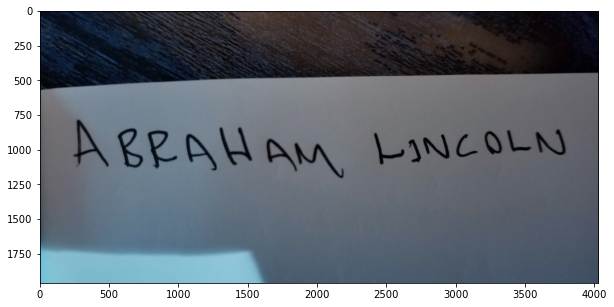

In [10]:
plt.figure(figsize = (18,5))
plt.imshow(img)

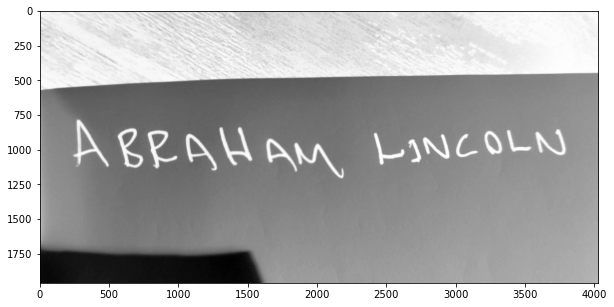

In [11]:
blurred = preprocess(img)
plt.figure(figsize = (18,5))
plt.imshow(blurred, cmap='Greys')

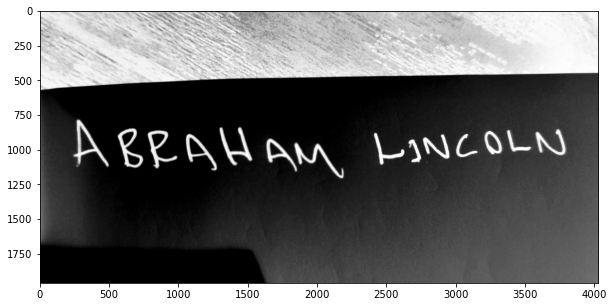

In [12]:
bright = brightness(blurred)
plt.figure(figsize = (18,5))
plt.imshow(bright, cmap='Greys')

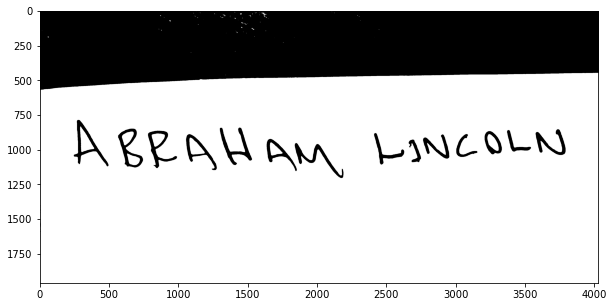

In [13]:
cnts, thresh = extract_contours(bright)
plt.figure(figsize = (18,5))
plt.imshow(thresh, cmap='Greys')

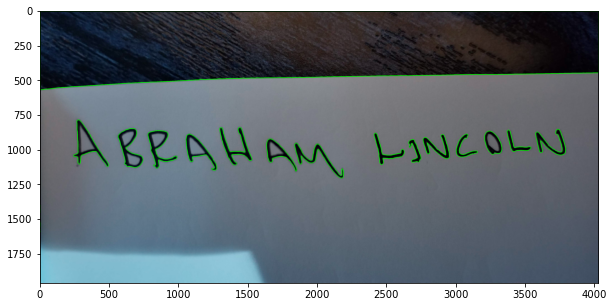

In [14]:
temp = img.copy()
cv2.drawContours(temp, cnts, -1, (0, 255, 0), 3)
plt.figure(figsize = (18,5))
plt.imshow(temp)

[INFO] A - 100.00%
[INFO] B - 100.00%
[INFO] R - 100.00%
[INFO] A - 99.99%
[INFO] H - 100.00%
[INFO] A - 99.84%
[INFO] M - 99.26%
[INFO] L - 100.00%
[INFO] J - 94.57%
[INFO] N - 100.00%
[INFO] C - 82.68%
[INFO] O - 99.99%
[INFO] L - 100.00%
[INFO] N - 100.00%


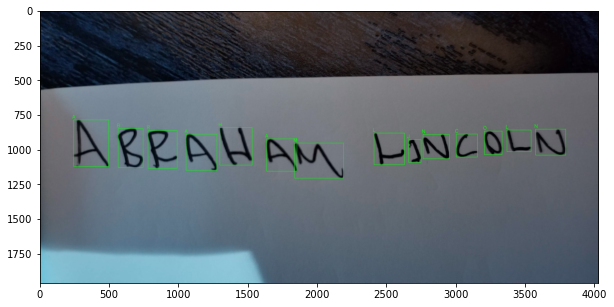

In [15]:
boxes, chars = extract_characters(cnts, blurred)
res_img, pred = predict(boxes, chars)
plt.figure(figsize = (18,5))
plt.imshow(res_img)

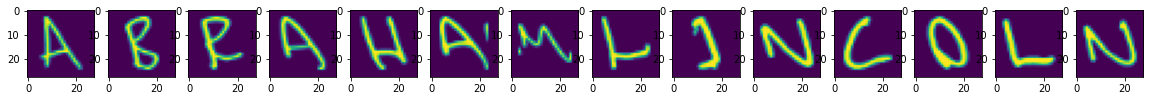

In [16]:
fig, ax = plt.subplots(1, len(chars), figsize=(20,5))
for i, char in enumerate(chars):
    ax[i].imshow(char)